### Temporal Analysis


#### Loading Dataset

In [1]:
import pandas as pd

# for drawing map
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_customer_seller

In [2]:
df = read_customer_seller()
df['total_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['day_name'] = df['order_delivered_carrier_date'].dt.day_name()
df.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cus_state,cus_lat,cus_lng,seller_state,seller_lat,seller_lng,total_days,day_name
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,SP,-23.574809,-46.587471,SP,-23.680114,-46.452454,8.0,Wednesday
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,BA,-12.169860,-44.988369,SP,-19.810119,-43.984727,13.0,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,GO,-16.746337,-48.514624,SP,-21.362358,-48.232976,9.0,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,RN,-5.767733,-35.275467,MG,-19.840168,-43.923299,13.0,Wednesday
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,SP,-23.675037,-46.524784,SP,-23.551707,-46.260979,2.0,Wednesday


#### Density of Deliveries per WeekDay
I want to see if there is any relationship with late delivery with the day of the week they reach to carrier from seller.

**Finding**\
Sunday bottleneck.\
Orders reaching carriers on Sunday suffer a double mean delivery time (24 days).\
The weekdays mean delivery time is (12 days).

In [3]:
new_df = df[['day_name', 'total_days']]
new_df = new_df.groupby('day_name').agg(['mean', 'std']).reset_index()
new_df

day_name total_days           
                   mean        std
0     Friday  12.299638   9.379469
1     Monday  11.654267   9.380943
2   Saturday  14.017967   9.962554
3     Sunday  24.416667  11.266575
4   Thursday  12.066950   9.559191
5    Tuesday  12.010510   9.618907
6  Wednesday  12.086915   9.550412

#### The "Regional Sunday" Interaction
Checking whether the **Sunday Bottleneck** is reginoal problem, or is effected in all states.

**Finding**\
The **Sunday Bottleneck** is found in all states. Some states do not accept orders on Sunday.\
Orders that get accepted on Saturday also have larger mean (~4 days+) in some states.

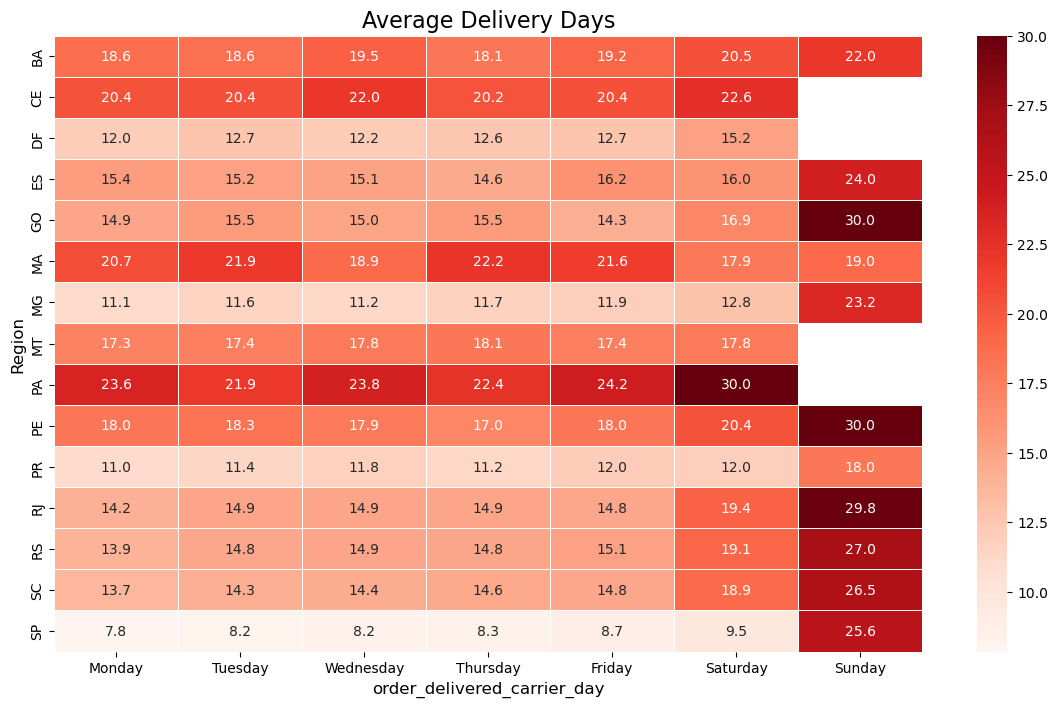

In [4]:
# 1. Define the correct order for days of the week for the plot axes
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 2. Filter for the Top 15 Regions by volume (to keep the heatmap readable)
top_regions = df['cus_state'].value_counts().nlargest(15).index
df_filtered = df[df['cus_state'].isin(top_regions)]

# 3. Create a Pivot Table: Rows = Regions, Columns = Day of Week, Values = Mean Delivery Time
pivot_table = df_filtered.pivot_table(
    values='total_days', 
    index='cus_state', 
    columns='day_name', 
    aggfunc='mean'
)

# 4. Reorder columns to follow the calendar week
pivot_table = pivot_table[day_order]

# 5. Plotting the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, cmap='Reds', fmt='.1f', linewidths=.5)

plt.title('Average Delivery Days', fontsize=16)
plt.xlabel('order_delivered_carrier_day', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.show()

#### Working Days (Order Accepting)

**Finding**\
Only around 10% of order are recorded on Saturday, and only 36 orders are recorded on Sunday over 27 States within 3 years period.\
This mean that Carrier Hub are not working or only partially opening on Weekend.

The 'Sunday' order are lost because of the FIFO theory, are they are just simply forgetten.




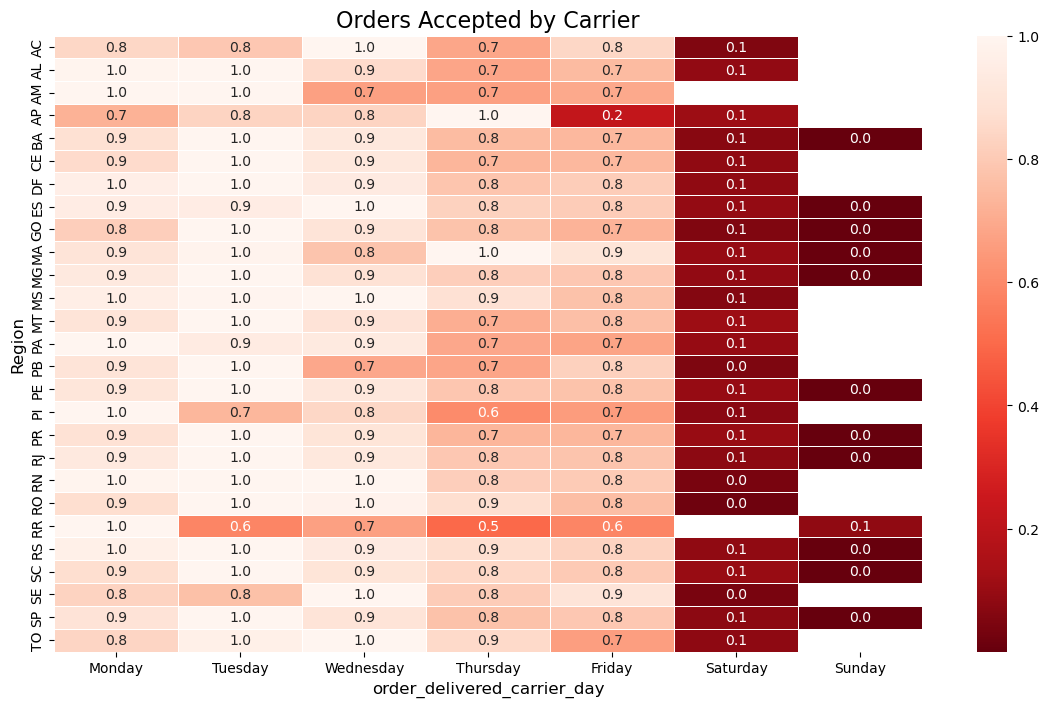

In [5]:
# 1. Create a Pivot Table: Rows = Regions, Columns = Day of Week, Values = Total Orders
pivot_table = df.pivot_table(
    values='order_id', 
    index='cus_state', 
    columns='day_name', 
    aggfunc='nunique'
)

# 2. Reorder columns to follow the calendar week
pivot_table = pivot_table[day_order]

# 3. Normalize pivot_table for better readablitly
row_max = pivot_table.max(axis=1)
normalized_pivot = pivot_table.div(row_max.replace(0, pd.NA), axis=0)

# 4. Plotting the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(normalized_pivot, annot=True, cmap='Reds_r', fmt='.1f', linewidths=.5)

plt.title('Orders Accepted by Carrier', fontsize=16)
plt.xlabel('order_delivered_carrier_day', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.show()

In [6]:
pivot_table['Sunday'].sum()

np.float64(36.0)

#### Working Days (Delivering)
There were fewer deliveries on Saturday, and Sunday.\
But, the percentage range from 10% to 40% state to state.\
Seems like the carrier are finishing the processing debts on Weekends.

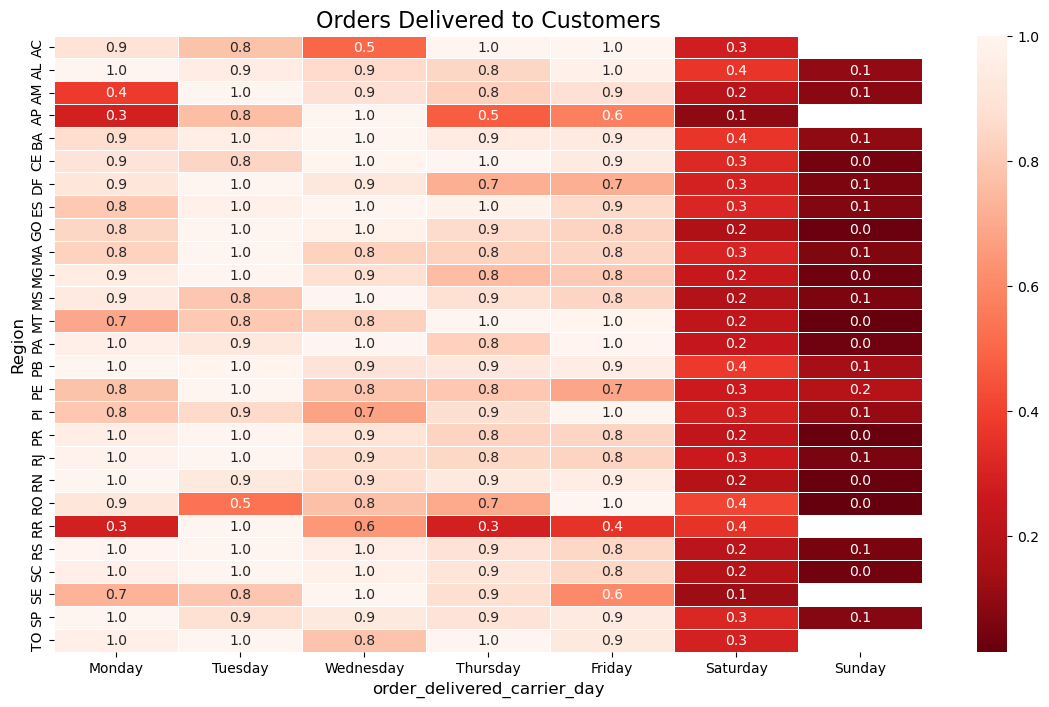

In [7]:
df['order_delivered_customer_day'] = df['order_delivered_customer_date'].dt.day_name()

# 1. Create a Pivot Table: Rows = Regions, Columns = Day of Week, Values = Total Orders
pivot_table = df.pivot_table(
    values='order_id', 
    index='cus_state', 
    columns='order_delivered_customer_day', 
    aggfunc='nunique'
)

# 2. Reorder columns to follow the calendar week
pivot_table = pivot_table[day_order]

# 3. Normalize pivot_table for better readablitly
row_max = pivot_table.max(axis=1)
normalized_pivot = pivot_table.div(row_max.replace(0, pd.NA), axis=0)

# 4. Plotting the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(normalized_pivot, annot=True, cmap='Reds_r', fmt='.1f', linewidths=.5)

plt.title('Orders Delivered to Customers', fontsize=16)
plt.xlabel('order_delivered_carrier_day', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.show()

In [8]:
pivot_table.sum()

order_delivered_customer_day
Monday       18858.0
Tuesday      18459.0
Wednesday    18028.0
Thursday     17062.0
Friday       17238.0
Saturday      5454.0
Sunday        1205.0
dtype: float64

#### Working Hours Window

Most order delivered to customers between 12:00 PM to 1:00 AM in the midnight.\
This pattern followed in most states, with few exception.

In [9]:
df['completed_hour'] = df['order_delivered_customer_date'].dt.hour
new_df = df[df['completed_hour'].notna()].copy()
new_df['completed_hour'] = new_df['completed_hour'].astype(int)

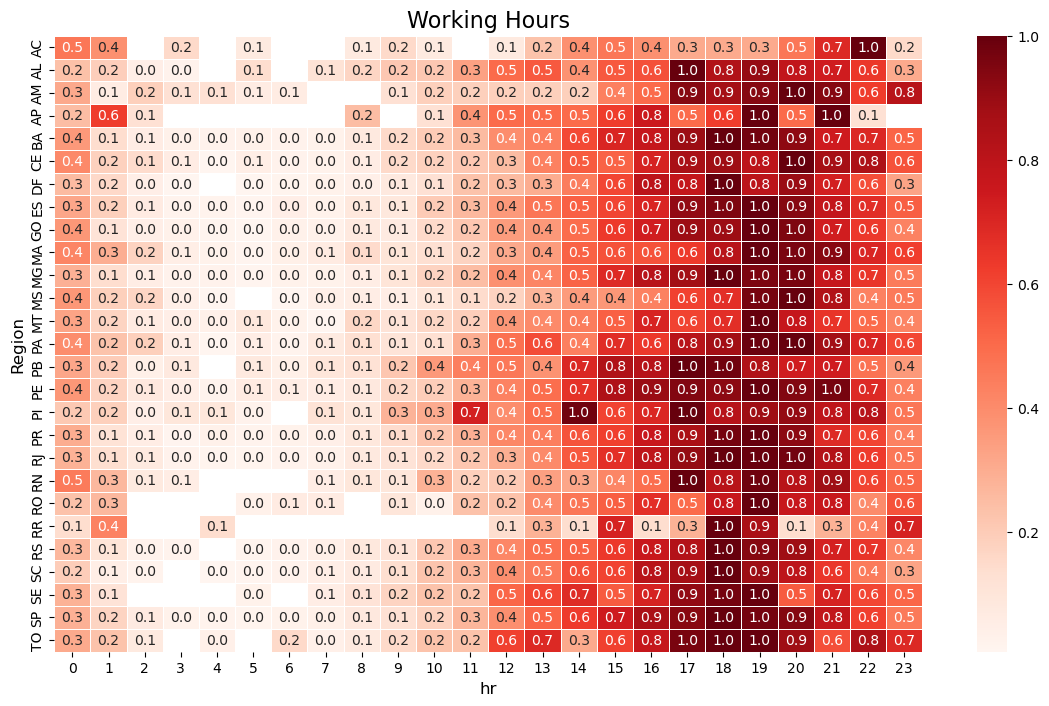

In [10]:
# 1. Create a Pivot Table: Rows = Regions, Columns = Hour, Values = Total Orders
pivot_table = new_df.pivot_table(
    values='order_id', 
    index='cus_state', 
    columns='completed_hour', 
    aggfunc='nunique'
)

# 2. Normalize pivot_table for better readablitly
row_max = pivot_table.max(axis=1)
normalized_pivot = pivot_table.div(row_max.replace(0, pd.NA), axis=0)

# 3. Plotting the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(normalized_pivot, annot=True, cmap='Reds', fmt='.1f', linewidths=.5)

plt.title('Working Hours', fontsize=16)
plt.xlabel('hr', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.show()

#### Workload
I want to check whether the delivery hub are under-staffed. Or, is it still under control.

**Finding**\
Workload seems undercontrol.\
There does not see huge gap beteen the number of `Order Registered vs. Order Delivered`.

<Axes: xlabel='date'>

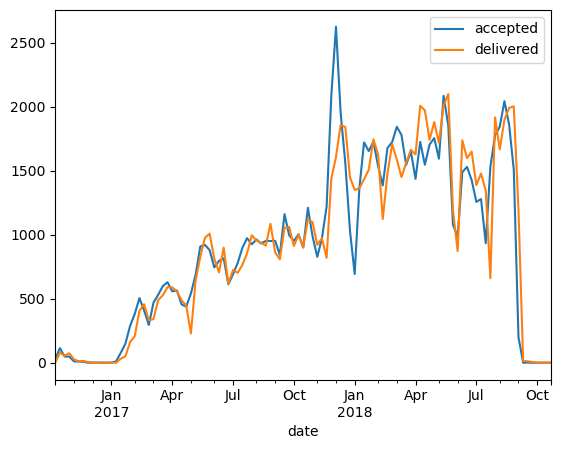

In [11]:
# 1. Filter the columns 
wide_df = df[['order_id']].copy()
wide_df['accepted'] = df['order_delivered_carrier_date'].dt.date
wide_df['delivered'] = df["order_delivered_customer_date"].dt.date

# Un-pivot 
long_df = wide_df.melt(
    id_vars="order_id",
    value_vars=["accepted", "delivered"],
    var_name="date_type",
    value_name="date"
)

# Summarize
counts = (
    long_df
    .groupby(["date", "date_type"])
    .size()
    .reset_index(name="count")
)

# Pivot column to plot line chart
final_df = (
    counts
    .pivot(index="date", columns="date_type", values="count")
    .fillna(0)
    .astype(int)
    .reset_index()
)
final_df['date'] = pd.to_datetime(final_df['date'])

# Sum Orders to check data Week by Week
weekly_trend = (
    final_df
    .groupby(pd.Grouper(key="date", freq="W-MON"))
    .agg(
        accepted=("accepted", "sum"),
        delivered=("delivered", "sum")
    )
    .reset_index()
)

weekly_trend = weekly_trend.set_index('date')
weekly_trend.plot()